In [1]:
#Import and uncompress the data

!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2024-12-31 05:49:41--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.173.216, 52.216.206.149, 52.216.241.46, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.173.216|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  19.2MB/s    in 0.7s    

2024-12-31 05:49:42 (19.2 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


In [2]:
#Inspection of dataset

import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
  data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [3]:
#Parse the data and import the data into numpy arrays

import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header)-1))
for i, line in enumerate(lines):
  values = [float(x) for x in line.split(",")[1:]]
  temperature[i] = values[1]
  raw_data[i,:] = values[:]

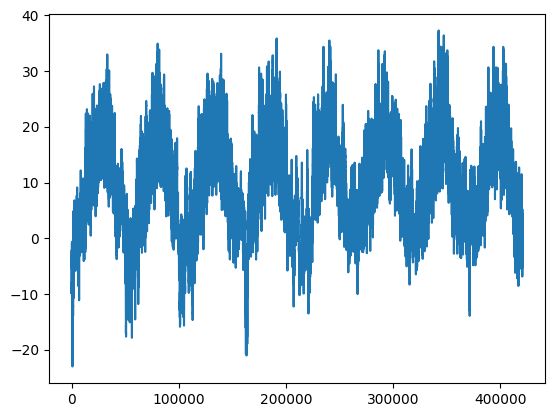

In [4]:
#Plot the temperature time series

from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

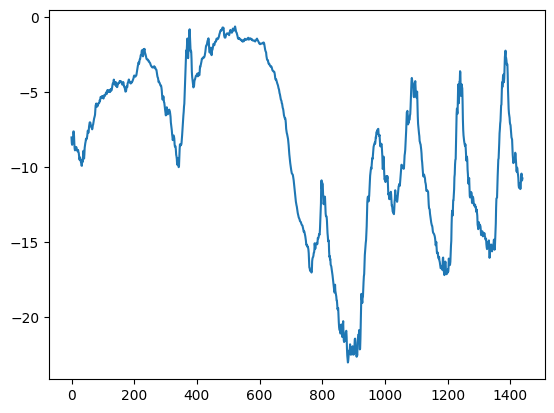

In [5]:
#Plotting the first 10 days of the temperature time series

plt.plot(range(1440), temperature[:1440])

In [6]:
#Computing the number of samples we will use for each data split

num_train_samples = int(0.5*len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples", num_train_samples)
print("num_val_samples", num_val_samples)
print("num_test_samples", num_test_samples)

num_train_samples 210225
num_val_samples 105112
num_test_samples 105114


In [7]:
#Normalizing the data

mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [8]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


In [9]:
#create dataset object to yield batches of data from past 5 days with a target
#temperature 24 hours into the future

from tensorflow import keras

sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples
)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples+num_val_samples
)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples+num_val_samples
)

In [10]:
#Inspecting output of one of the datasets

for samples, targets in train_dataset:
  print("samples shape:", samples.shape)
  print("targets shape:", targets.shape)
  break

samples shape: (256, 120, 14)
targets shape: (256,)


In [11]:
#Computing the common sense baseline Mean Absolute Error (MAE)

def evaluate_naive_method(dataset):
  total_abs_err = 0.
  samples_seen = 0
  for samples, targets in dataset:
    preds = samples[:,-1,1] * std[1] + mean[1]
    total_abs_err += np.sum(np.abs(preds-targets))
    samples_seen += samples.shape[0]
  return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


In [12]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
# Get the input shape
input_shape = inputs.shape
# Use the input shape when flattening
x = layers.Reshape((input_shape[1]*input_shape[2],))(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - loss: 18.5130 - mae: 3.2597 - val_loss: 10.7661 - val_mae: 2.5861
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 47s 57ms/step - loss: 9.5072 - mae: 2.4227 - val_loss: 10.9555 - val_mae: 2.6073
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 45s 54ms/step - loss: 8.6199 - mae: 2.3106 - val_loss: 10.7177 - val_mae: 2.5865
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 81s 54ms/step - loss: 8.0497 - mae: 2.2344 - val_loss: 10.3703 - val_mae: 2.5416
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 92s 66ms/step - loss: 7.6396 - mae: 2.1772 - val_loss: 12.0386 - val_mae: 2.7502
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 48s 59ms/step - loss: 7.3627 - mae: 2.1354 - val_loss: 14.3157 - val_mae: 3.0234
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 84s 61ms/step - loss: 7.1611 - mae: 2.1088 - val_loss: 11.1880 - val_mae: 2.6514
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 72s 49ms/step - loss: 7.0254 - mae: 2.0916 - val_loss: 15.7017 - val_mae: 3.1823
Epoch 9/10
819/819 ━━━━━━━━━━━━

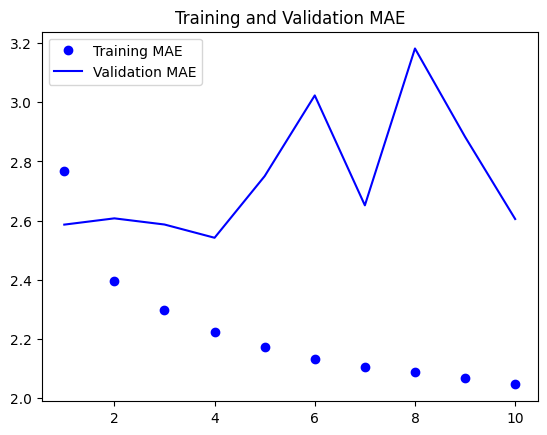

In [13]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss)+1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and Validation MAE")
plt.legend()
plt.show()

In [15]:
#Numpy Implementation of a Simple RNN

import numpy as np
timesteps = 100
input_features = 32
output_features = 64
inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))
successive_outputs = []
for input_t in inputs:
  output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
  successive_outputs.append(output_t)
  state_t = output_t
final_output_sequence = np.stack(successive_outputs, axis=0)

In [16]:
#An RNN layer example
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

In [17]:
#An RNN layer that returns only its last output step

num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs)
print(outputs.shape)

(None, 16)


In [18]:
#An RNN layer that returns its full output sequence

num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)
print(outputs.shape)

(None, 120, 16)


In [19]:
#Stacking RNN layers

inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)

In [14]:
#Now implementing a LSTM-based model

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 57s 67ms/step - loss: 77.1116 - mae: 6.7535 - val_loss: 13.4935 - val_mae: 2.7741
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 50s 61ms/step - loss: 12.5227 - mae: 2.7205 - val_loss: 9.2136 - val_mae: 2.3589
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 48s 58ms/step - loss: 10.0413 - mae: 2.4589 - val_loss: 9.2257 - val_mae: 2.3451
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 49s 59ms/step - loss: 9.3211 - mae: 2.3722 - val_loss: 9.5887 - val_mae: 2.3992
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 40s 48ms/step - loss: 8.9015 - mae: 2.3217 - val_loss: 9.0969 - val_mae: 2.3405
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 39s 47ms/step - loss: 8.5730 - mae: 2.2836 - val_loss: 9.2803 - val_mae: 2.3686
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 39s 48ms/step - loss: 8.3151 - mae: 2.2489 - val_loss: 9.2235 - val_mae: 2.3620
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 40s 48ms/step - loss: 8.1037 - mae: 2.2186 - val_loss: 9.2396 - val_mae: 2.3602
Epoch 9/10
819/819 ━━━━━━━━━━━━━━━━━

In [23]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 227s 274ms/step - loss: 49.0674 - mae: 5.1819 - val_loss: 9.6642 - val_mae: 2.4235
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 236s 242ms/step - loss: 15.4378 - mae: 3.0569 - val_loss: 9.5267 - val_mae: 2.4081
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 220s 269ms/step - loss: 14.5803 - mae: 2.9679 - val_loss: 9.2895 - val_mae: 2.3711
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 245s 248ms/step - loss: 14.0950 - mae: 2.9143 - val_loss: 8.9188 - val_mae: 2.3193
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 240s 221ms/step - loss: 13.7453 - mae: 2.8739 - val_loss: 8.9655 - val_mae: 2.3172
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 202s 222ms/step - loss: 13.3848 - mae: 2.8407 - val_loss: 8.8371 - val_mae: 2.3052
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 201s 221ms/step - loss: 13.1011 - mae: 2.8092 - val_loss: 8.9722 - val_mae: 2.3174
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 180s 220ms/step - loss: 12.7323 - mae: 2.7726 - val_loss: 9.0565 - val_mae: 2.3310
Epoch 9/10
819/8

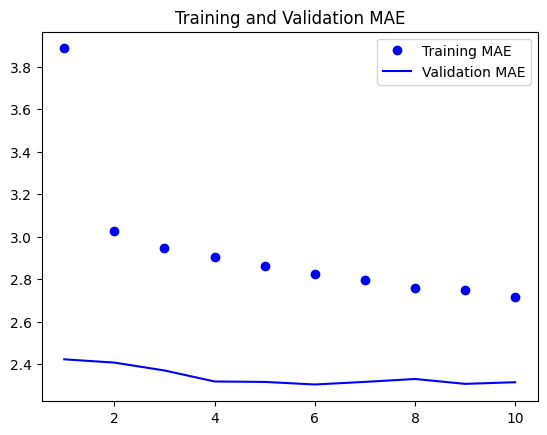

In [24]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss)+1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and Validation MAE")
plt.legend()
plt.show()

In [26]:
#Training and evaluating a dropout-regularized, stacked GRU (Gated Recurrent Unit) model

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data = val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

In [ ]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss)+1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and Validation MAE")
plt.legend()
plt.show()

In [ ]:
#Training and evaluating a bidirectional LSTM

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_bidirectional_lstm.keras",
                                    save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks = callbacks)
model = keras.load_model("jena_bidirectional_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")